# Load Libraries

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import sys
import scipy.io
import os
import sys
from pathlib import Path
import pickle
from gc import collect
from glob import glob
from datetime import datetime
import traceback
from time import sleep
import matplotlib.dates as mdates
#import speasy


#Important!! Make sure your current directory is the MHDTurbPy folder!
os.chdir("/Users/nokni/work/MHDTurbPy/")


# Make sure to use the local spedas
sys.path.insert(0, os.path.join(os.getcwd(), 'pyspedas'))
import pyspedas
from pyspedas.utilities import time_string
from pytplot import get_data


""" Import manual functions """

sys.path.insert(1, os.path.join(os.getcwd(), 'functions'))
import calc_diagnostics as calc
import TurbPy as turb
import general_functions as func
import Figures as figs
from   SEA import SEA

os.chdir("/Users/nokni/work/3d_anisotropy/")
sys.path.insert(1, os.path.join(os.getcwd(), '3D_anis_funcs/'))
import three_D_funcs as threeD

# Better figures
from matplotlib import pyplot as plt
plt.style.use(['science', 'scatter'])
plt.rcParams['text.usetex'] = True

import os
os.environ["CDF_LIB"] = "/Applications/cdf/cdf/lib"

import warnings
warnings.filterwarnings('ignore')


from cdasws import CdasWs
cdas = CdasWs()

This unreleased version of SpacePy is not supported by the SpacePy team.


# Loading WIND Data and Validating with Alternative Methods

In [2]:
# user defined parameters
max_hours                = 16      # Max hours to consider (in terms of lags)
Estimate_5point          = False   # Added functionality for 5 point structure functions. Check https://iopscience.iop.org/article/10.3847/1538-4357/ab99ca/pdf
return_flucs             = False   # Wether to return δb's or estimate Sfuncs.
consider_Vsc             = True    # Taki into account the spacecraft velocity in RTN
keep_wave_coeefs         = False   # Do th CWT analysis
dj_wave                  = 1/4     # Used for spacing between samples in CWT (more samples as denom increases).            
strict_thresh            = True    # Stricter thresholds
estimate_alignment_angle = True
return_mag_align_correl  = False
only_general             = False   # Only keep overall sfunctions (don't do anisotropy analysis) 
duration                 = 8
step                     = 4
qorder                   = np.arange(1, 9)

# Load Podesta's intervals
start_times              = ['1995-01-01', '1996-05-15', '1997-01-08', '2000-08-23']
end_times                = ['1995-07-29', '1996-08-16', '1997-06-09', '2001-02-15']

# Save results
save_path                = '/Users/nokni/work/3d_anisotropy/podesta_test/'
 
if only_general:
    theta_thresh_gen = 50
    phi_thresh_gen   = 50
else:
    theta_thresh_gen = None
    phi_thresh_gen   = None
    
if strict_thresh:
    conditions        = {
                           'ell_perp'      : {'theta': 85, 'phi': 85},
                           'Ell_perp'      : {'theta': 85, 'phi': 5},
                           'ell_par'       : {'theta': 5, 'phi':  90},
                           'ell_par_rest'  : {'theta': 5, 'phi':  5},
                         }    
else:
    conditions        = {
                           'ell_perp'      : {'theta': 80, 'phi': 80},
                           'Ell_perp'      : {'theta': 80, 'phi': 10},
                           'ell_par'       : {'theta': 10, 'phi': 90},
                           'ell_par_rest'  : {'theta': 10, 'phi': 10},
                         }

# Load data
for metr in range(len(start_times)):
    start_time = start_times[metr]
    end_time   = end_times[metr]
    
    vars         = ['MOM.P.MAGF','MOM.P.DENSITY','MOM.P.VELOCITY','TIME']
    time         = [start_time, end_time]
    status, data = cdas.get_data('WI_PLSP_3DP', vars, time[0], time[1])


    # Create dataframes for B, V, and N
    B = pd.DataFrame({'DateTime': data['Epoch'],
                      'Br': data['MOM$P$MAGF'].T[0],
                      'Bt': data['MOM$P$MAGF'].T[1],
                      'Bn': data['MOM$P$MAGF'].T[2]
                     }).set_index('DateTime').interpolate()

    V = pd.DataFrame({'DateTime': data['Epoch'],
                      'Vr': data['MOM$P$VELOCITY'].T[0],
                      'Vt': data['MOM$P$VELOCITY'].T[1],
                      'Vn': data['MOM$P$VELOCITY'].T[2]
                     }).set_index('DateTime').interpolate()

    N = pd.DataFrame({'DateTime': data['Epoch'],
                      'N': data['MOM$P$DENSITY']
                     }).set_index('DateTime').interpolate()
    
    # Estimate lags
    dt          = func.find_cadence(B)
    max_lag     = int((max_hours*3600)/dt)
    tau_values  = np.unique((1.3**np.arange(0, 1000)).astype(int))
    tau_values  = tau_values[(tau_values<max_lag) & (tau_values>0)]

    Np = N[~np.isinf(N.values)]
    
    Vsw_norm = np.nanmean(np.sqrt(V.Vr.values**2 + V.Vt.values**2 + V.Vn.values**2))
    Vsw      = np.nanmean(np.sqrt(V.Vr.values**2 + V.Vt.values**2 + V.Vn.values**2))
    di       = 228/np.sqrt(N.N.values)
    di       = np.nanmean(di[~np.isinf(di)])



    # Try CWT method
    if keep_wave_coeefs:

        Wx, Wy, Wz, freqs, PSD, scales = turb.trace_PSD_wavelet(B.Br.values,
                                                                B.Bt.values,
                                                                B.Bn.values, 
                                                                dt,
                                                                dj_wave)

        # Create dictionary
        keep_wave_coeff = {'Wx': Wx, 'Wy': Wy, 'Wz': Wz, 'freqs':freqs, 'PSD':PSD, 'scales': scales, 'di':di, 'Vsw_RTN':Vsw, 'Vsw_minus_Vsc':Vsw_norm, 'dt':dt }

        del Wx, Wy, Wz

        # Save dictionary
        if strict_thresh:
            func.savepickle(keep_wave_coeff, save_path, 'wave_coeffs_5deg.pkl')               
        else:
            func.savepickle(keep_wave_coeff, save_path, 'wave_coeffs.pkl')

        del keep_wave_coeff
    else:
        max_lag     = int((max_hours*3600)/dt)
        tau_values  = 1.2**np.arange(0, 1000)
        max_ind     = (tau_values<max_lag) & (tau_values>0)
        scales  = np.unique(tau_values[max_ind].astype(int))

    # Create an empty list to store the final results
    thetas, phis, flucts, ell_di, Sfunctions, PDFs, overall_align_angles = threeD.estimate_3D_sfuncs(B,
                                                                                                     V, 
                                                                                                     Np,
                                                                                                     dt,
                                                                                                     Vsw_norm, 
                                                                                                     di, 
                                                                                                     conditions,
                                                                                                     qorder, 
                                                                                                     scales, 
                                                                                                     estimate_PDFS            = False,
                                                                                                     return_unit_vecs         = False,
                                                                                                     five_points_sfuncs       = Estimate_5point,
                                                                                                     estimate_alignment_angle = estimate_alignment_angle,
                                                                                                     return_mag_align_correl  = return_mag_align_correl,
                                                                                                     return_coefs             = return_flucs,
                                                                                                     only_general             = only_general,
                                                                                                     theta_thresh_gen         = theta_thresh_gen,
                                                                                                     phi_thresh_gen           = phi_thresh_gen
                                                                                                )


    keep_sfuncs_5point = {'di':di, 'Vsw':Vsw, 'Vsw_norm': Vsw_norm, 'ell_di':ell_di,'Sfuncs':Sfunctions, 'flucts':flucts}

    # Save results pertaining to 5pt-SF
    if only_general:
        func.savepickle(keep_sfuncs_5point, save_path+'/'+start_time+'_'+end_time+'/', 'general_Sfuncs_th'+str(theta_thresh_gen)+'_th'+str(phi_thresh_gen)+'.pkl')
    else:
        if strict_thresh:
            func.savepickle(keep_sfuncs_5point, save_path+'/'+start_time+'_'+end_time+'/', '5point_sfuncs_5deg.pkl')              
        else:
            func.savepickle(keep_sfuncs_5point, save_path+'/'+start_time+'_'+end_time+'/', '5point_sfuncs.pkl')
    func.savepickle(overall_align_angles, save_path+'/'+start_time+'_'+end_time+'/', 'align_angles.pkl')

    # Save some space for ram
    del keep_sfuncs_5point

    if keep_wave_coeefs:

        # We want to prevent saving tons of data (phis, thetas). For this reason we will load the 'wave_coeffs.pkl' file again.
        # We will once again use the conditionals for the angles. Keep the wavelet coefficients we want for each category
        # Then we will overwrite the previous version of 'wave_coeffs.pkl'

        # First load
        if strict_thresh:
            wave_coeffs =  pd.read_pickle(str(os.path.join(save_path+'/'+start_time+'_'+end_time+'/', 'wave_coeffs_5deg.pkl') ))                
        else:
            wave_coeffs =  pd.read_pickle(str(os.path.join(save_path+'/'+start_time+'_'+end_time+'/', 'wave_coeffs.pkl') ))

        ell_perp_dict, Ell_perp_dict, ell_par_dict, ell_par_rest_dict = collect_wave_coeffs.keep_conditioned_coeffs(
                                                                                                                    np.hstack(list(phis.values())),
                                                                                                                    np.hstack(list(thetas.values())),
                                                                                                                    wave_coeffs,
                                                                                                                    conditions)
        keep_wave_coeff = {'ell_perp'           : ell_perp_dict,
                           'Ell_perp'           : Ell_perp_dict,
                           'ell_par'            : ell_par_dict,
                           'ell_par_rest_dict'  : ell_par_rest_dict,
                           'freqs'              : freqs,
                           'PSD'                : PSD,  
                           'di'                 : di,
                           'Vsw_RTN'            : Vsw, 
                           'Vsw_minus_Vsc'      : Vsw_norm,
                           'dt'                 : dt }
        # Save dictionary
        if strict_thresh:
            func.savepickle(keep_wave_coeff, save_path+'/'+start_time+'_'+end_time+'/', 'wave_coeffs_5deg.pkl')               
        else:
            func.savepickle(keep_wave_coeff, save_path+'/'+start_time+'_'+end_time+'/', 'wave_coeffs.pkl')

        del thetas, phis, wave_coeffs, ell_perp_dict, Ell_perp_dict, ell_par_dict, ell_par_rest_dict




OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


# Plot alignment angles

In [104]:

fnames

array(['/Users/nokni/work/3d_anisotropy/podesta_test/1995-01-01_1995-07-29/align_angles.pkl',
       '/Users/nokni/work/3d_anisotropy/podesta_test/1996-05-15_1996-08-16/align_angles.pkl',
       '/Users/nokni/work/3d_anisotropy/podesta_test/1997-01-08_1997-06-09/align_angles.pkl',
       '/Users/nokni/work/3d_anisotropy/podesta_test/2000-08-23_2001-02-15/align_angles.pkl'],
      dtype='<U83')

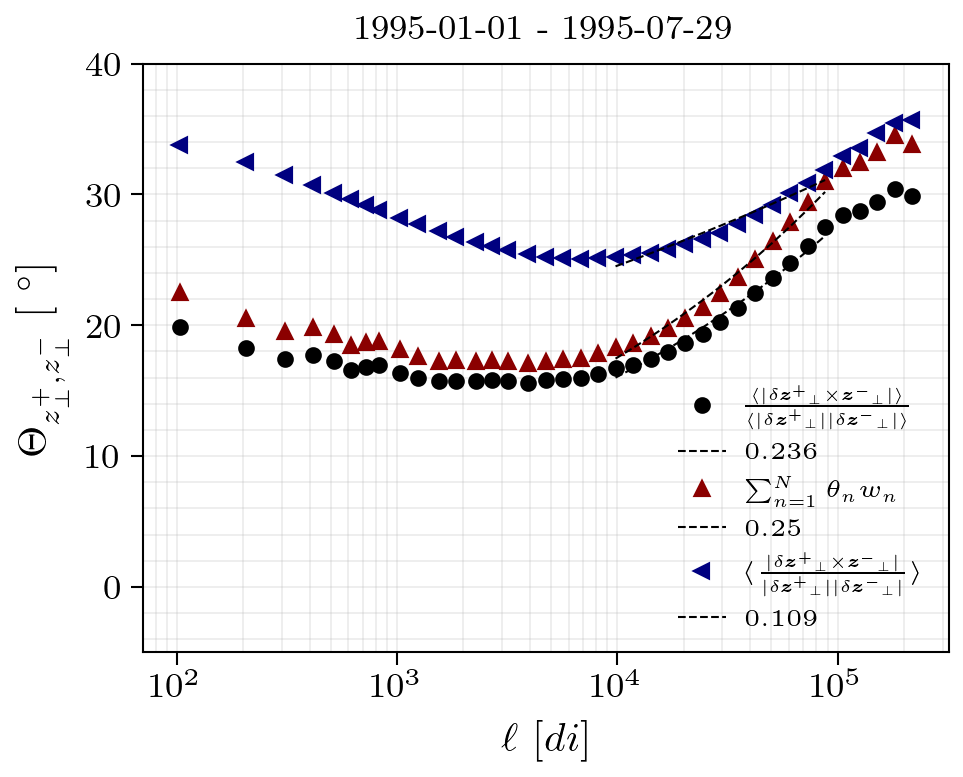

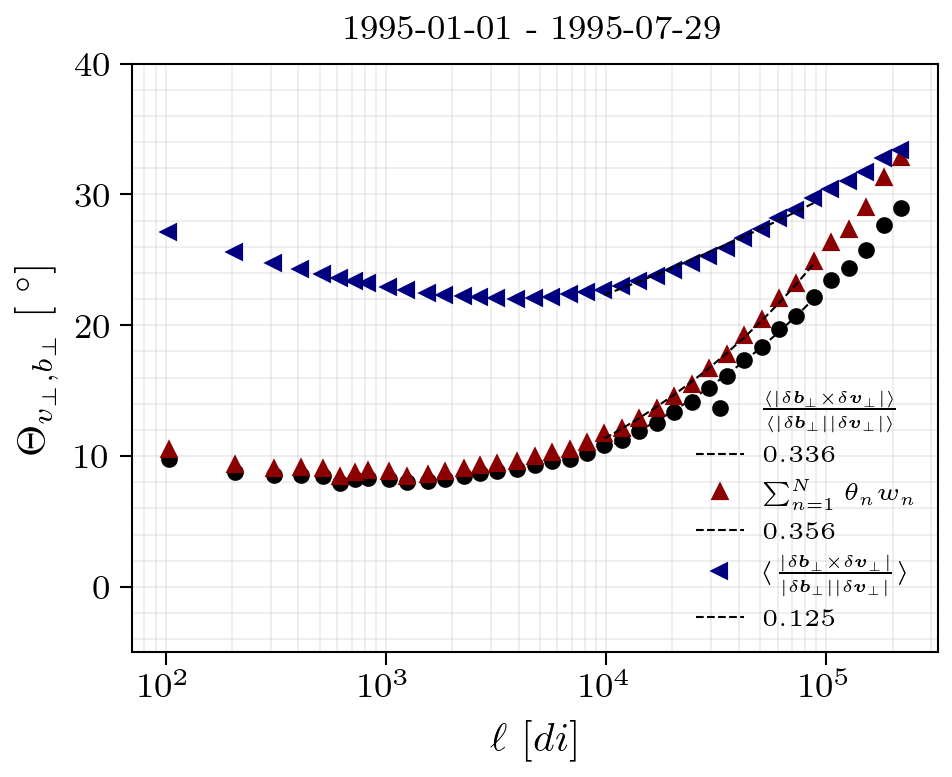

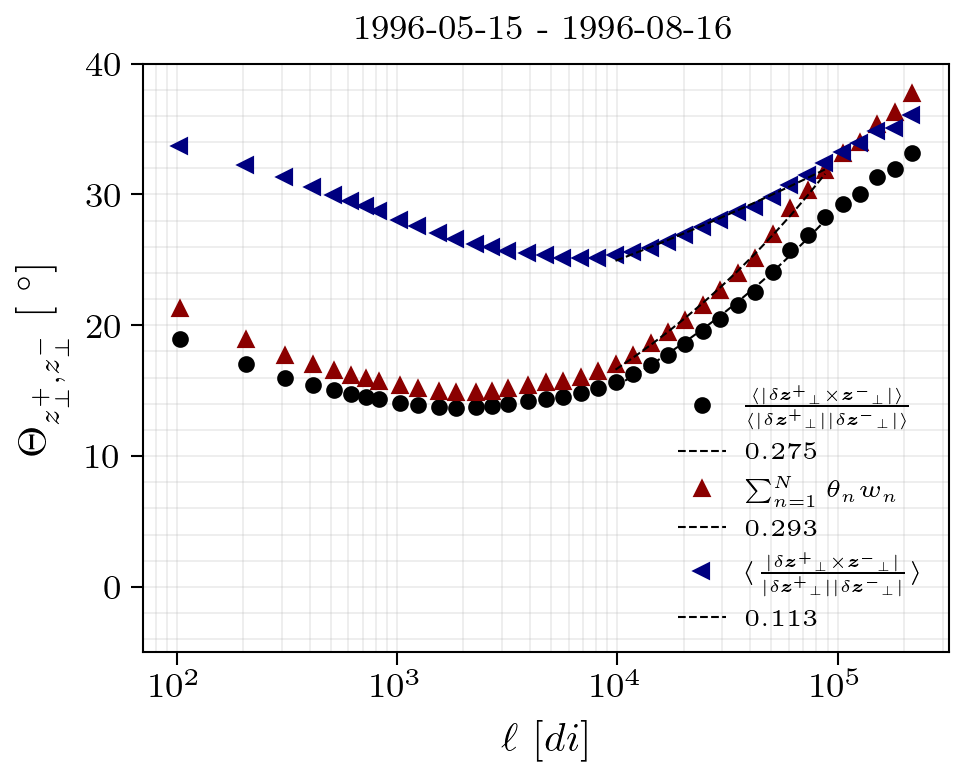

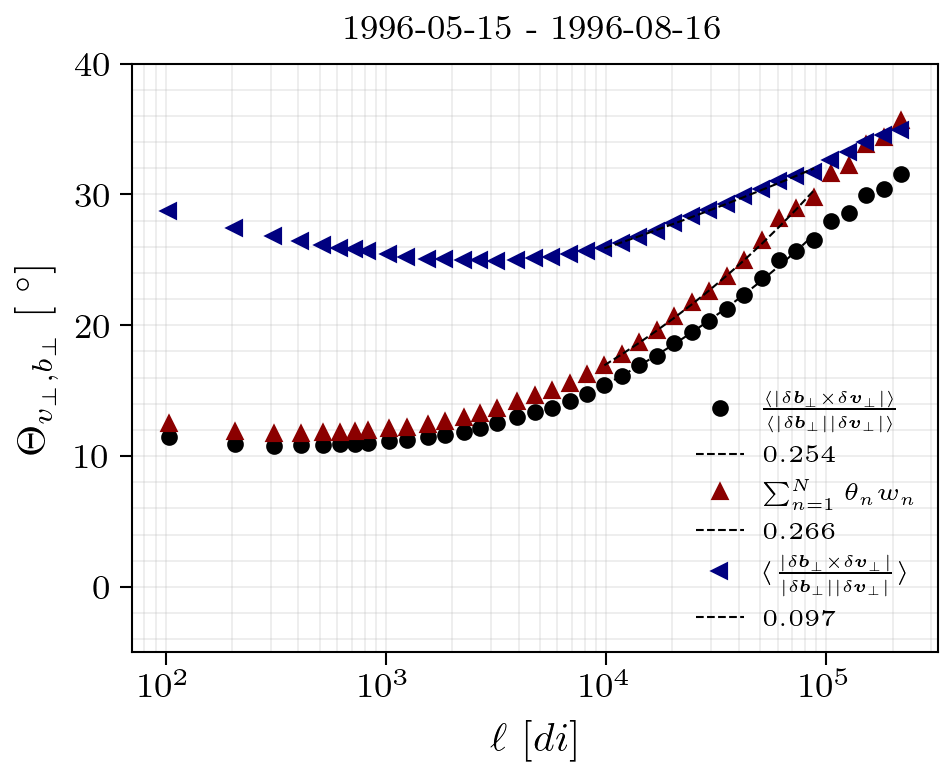

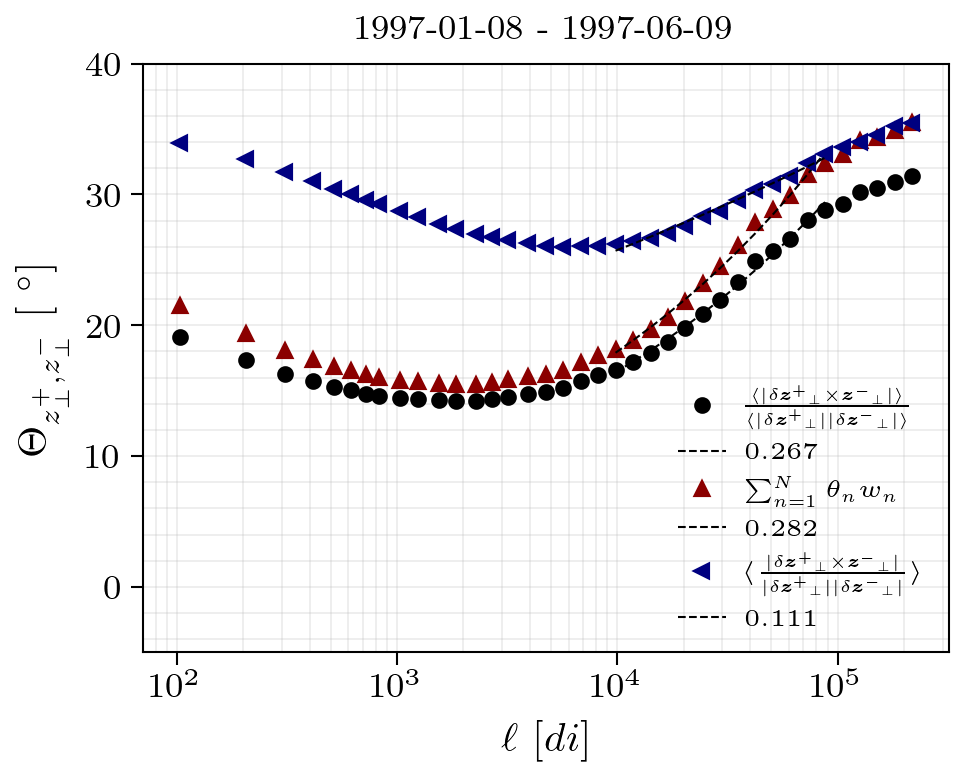

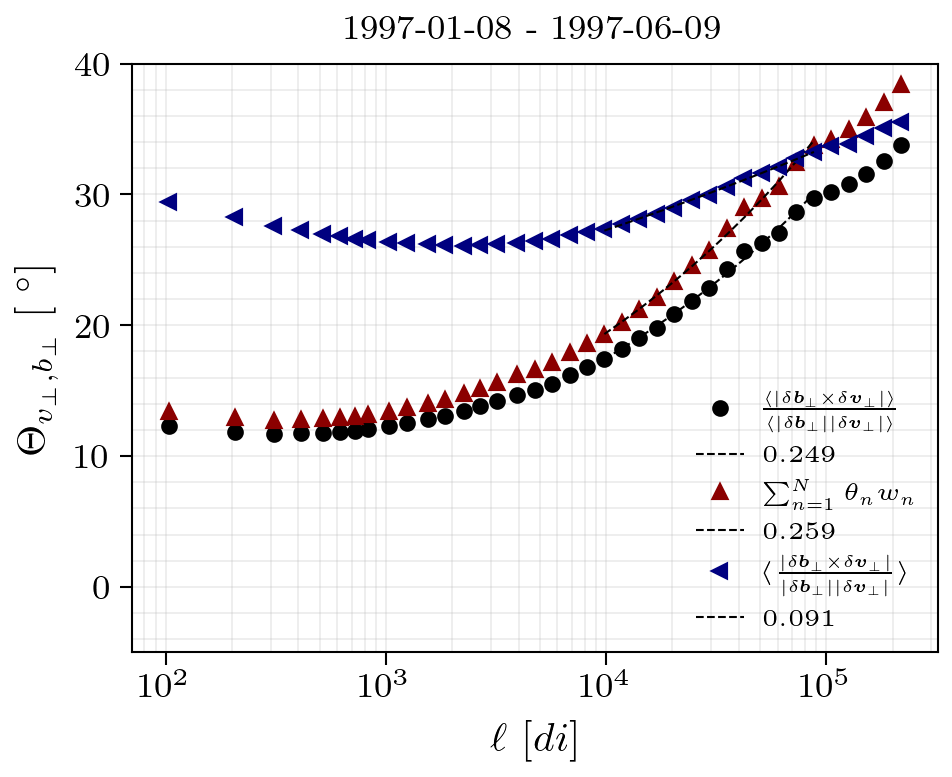

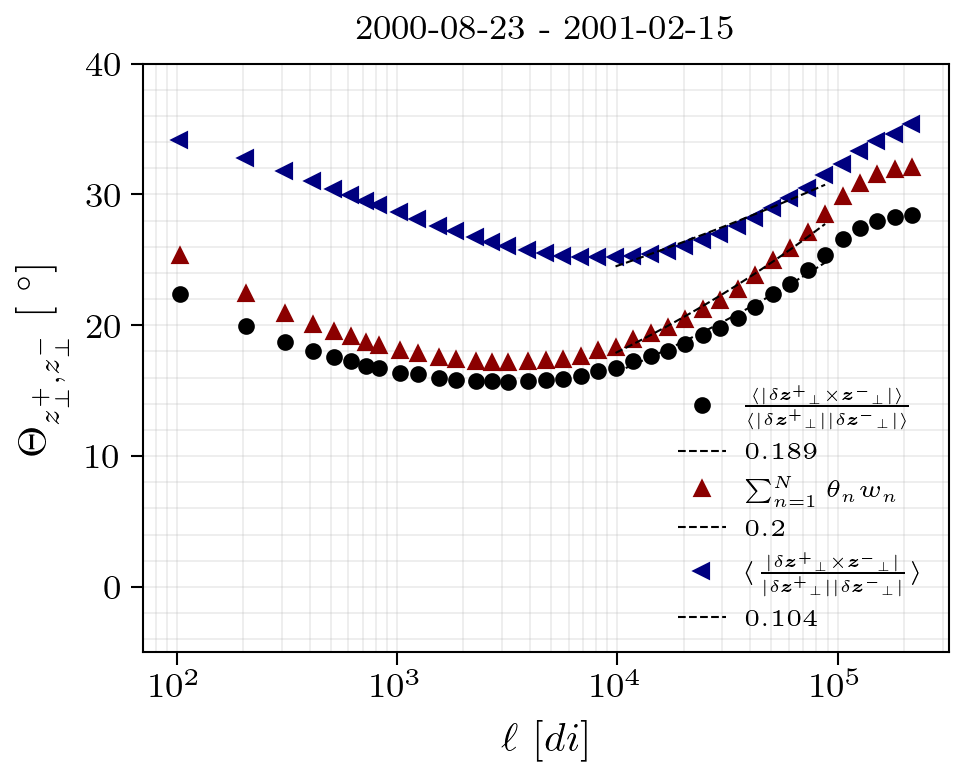

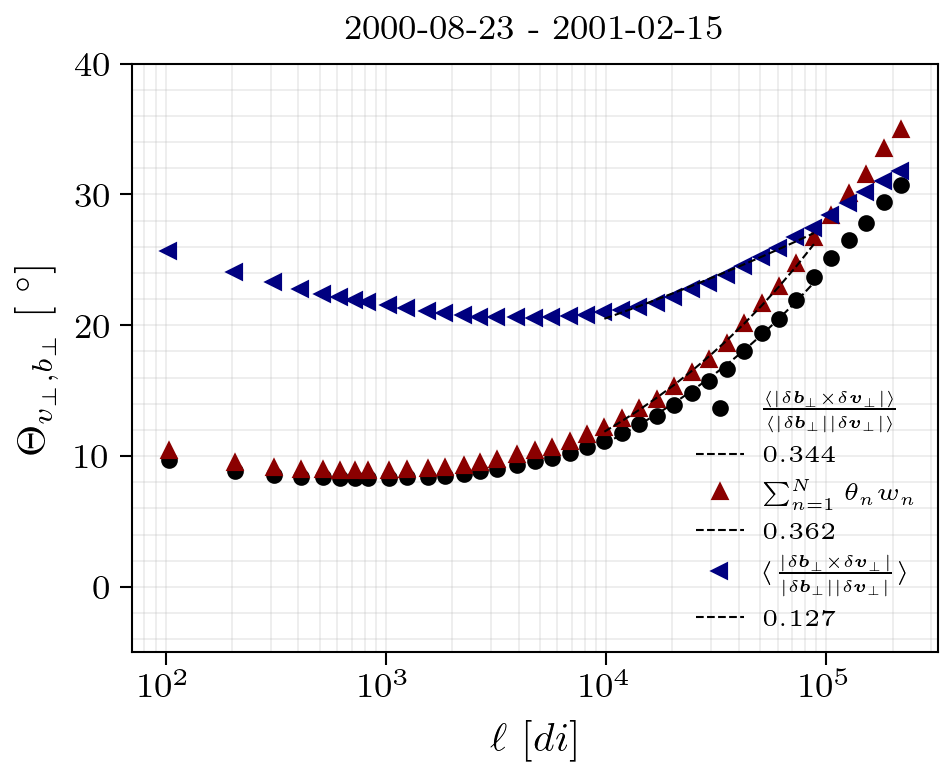

In [107]:
import glob

x01, xf1    = 1e4, 1e5
whichs      = ['polar','weighted', 'reg']
cols        = ['k', 'darkred', 'navy']
whos        = ['Zpm', 'VB']
start_times = ['1995-01-01', '1996-05-15', '1997-01-08', '2000-08-23']
end_times   = ['1995-07-29', '1996-08-16', '1997-06-09', '2001-02-15']
labelsVB      = [
                r'$\frac{\langle |\delta \boldsymbol{b}_{\perp} \times \delta\boldsymbol{v}_{\perp}| \rangle}{ \langle |\delta \boldsymbol{b}_{\perp}| |\delta  \boldsymbol{v}_{\perp}| \rangle}$',
                r'$\sum_{n=1}^{N} \theta_{n} w_{n}$',
                r'$ \langle  \frac{|\delta \boldsymbol{b}_{\perp} \times \delta\boldsymbol{v}_{\perp}| }{  |\delta \boldsymbol{b}_{\perp}| |\delta  \boldsymbol{v}_{\perp}| }\rangle$',
              ]
labelsZpm      = [
                r'$\frac{\langle |\delta \boldsymbol{z^{+}}_{\perp} \times \boldsymbol{z^{-}}_{\perp}| \rangle}{ \langle |\delta \boldsymbol{z^{+}}_{\perp}| |\delta  \boldsymbol{z^{-}}_{\perp}| \rangle}$',
                r'$\sum_{n=1}^{N} \theta_{n} w_{n}$',
                r'$ \langle  \frac{|\delta \boldsymbol{z^{+}}_{\perp} \times \boldsymbol{z^{-}}_{\perp}| }{  |\delta \boldsymbol{z^{+}}_{\perp}| |\delta  \boldsymbol{z^{-}}_{\perp}| }\rangle$',
              ]
fnames = np.sort(glob.glob(str(Path('/Users/nokni/work/3d_anisotropy/podesta_test/').joinpath('*').joinpath('align_angles.pkl'))))

for j, fname in enumerate(fnames):
    overall_align_angles =pd.read_pickle(fname)
    
    


    for  who in whos:
        if who =='Zpm':
            fig, ax = figs.initializeFigure(r'$\Theta_{z_{\perp}^{+},z_{\perp}^{-}} ~ [~ ^{\circ}]$', r'$\ell ~[di]$', '2col')
        else:
            fig, ax = figs.initializeFigure(r'$\Theta_{v_{\perp},b_{\perp}} ~ [~ ^{\circ}]$', r'$\ell ~[di]$', '2col')            
        
        for  ii, which in enumerate(whichs):
            if who =='Zpm':
                plt.loglog(ell_di,np.arcsin(overall_align_angles[who][which])*180/np.pi,c =cols[ii], label = labelsZpm[ii])
            else:
                plt.loglog(ell_di,np.arcsin(overall_align_angles[who][which])*180/np.pi,c =cols[ii], label = labelsVB[ii])                

            fit1, s1, e1, x1, y1 =func.find_fit(ell_di, np.arcsin(overall_align_angles[who][which])*180/np.pi, x01, xf1)
            plt.loglog(x1[s1:e1], fit1[2], ms=0,c='k', ls='--', lw=0.5, label =round(fit1[0][1],3))

            plt.yscale('linear')
            plt.legend(fontsize ='xx-small', loc=4)
            plt.title(start_times[j]+' - '+end_times[j], fontsize ='small')
            
            
            
            # Axis grids
            ax.xaxis.grid(True, "minor", linewidth=.1, ls='-');  
            ax.yaxis.grid(True, "major", linewidth=.1, ls='-');
            ax.yaxis.grid(True, "minor", linewidth=.1, ls='-');  
            ax.xaxis.grid(True, "major", linewidth=.1, ls='-');    
    
            plt.ylim([-5,40])
        
        
            if who =='Zpm':
                fig.savefig(r"/Users/nokni/work/3d_anisotropy/figures/test_podesta/"+start_times[j]+' - '+end_times[j]+"_zpm.png", format='png',dpi=300,bbox_inches='tight')
            else:
                fig.savefig(r"/Users/nokni/work/3d_anisotropy/figures/test_podesta/"+start_times[j]+' - '+end_times[j]+"_vb.png", format='png',dpi=300,bbox_inches='tight')

                

# Giannis code

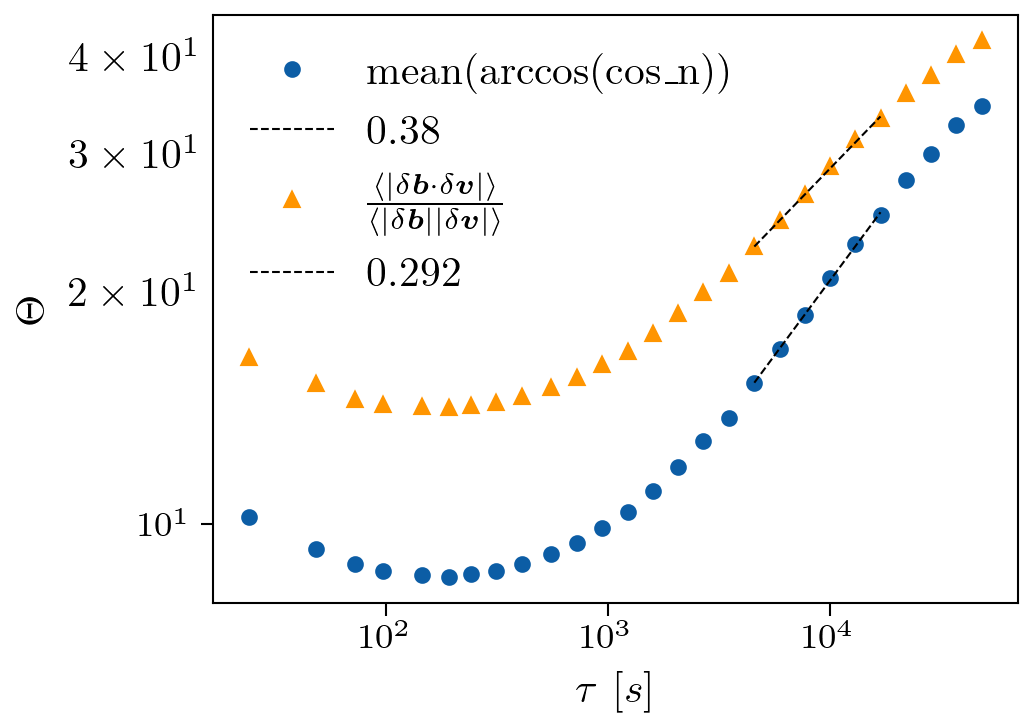

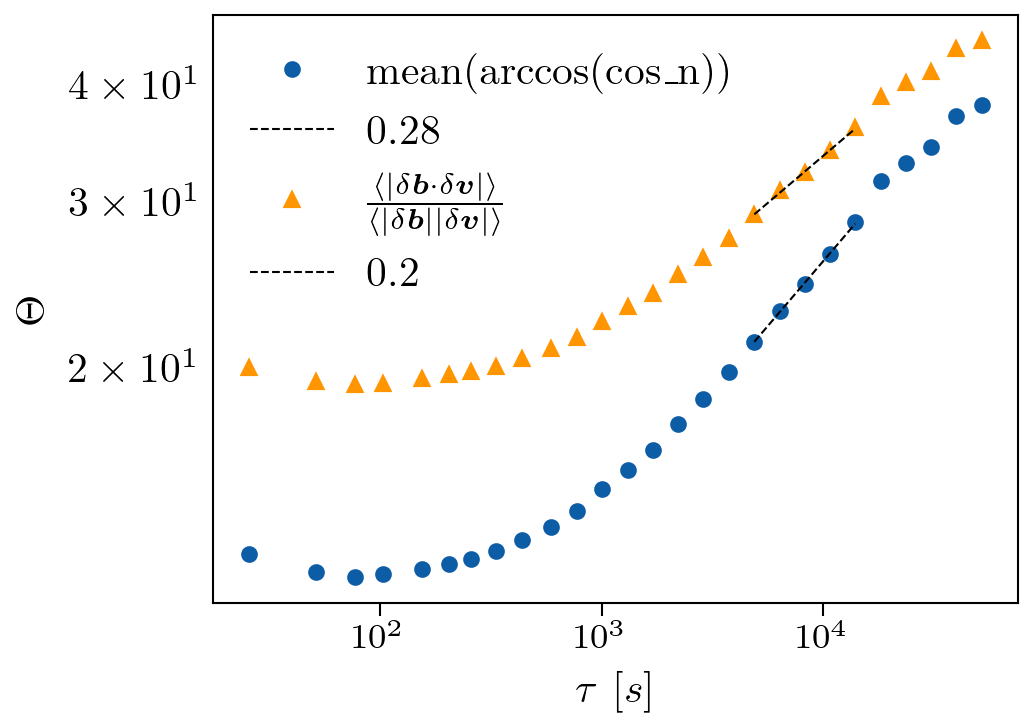

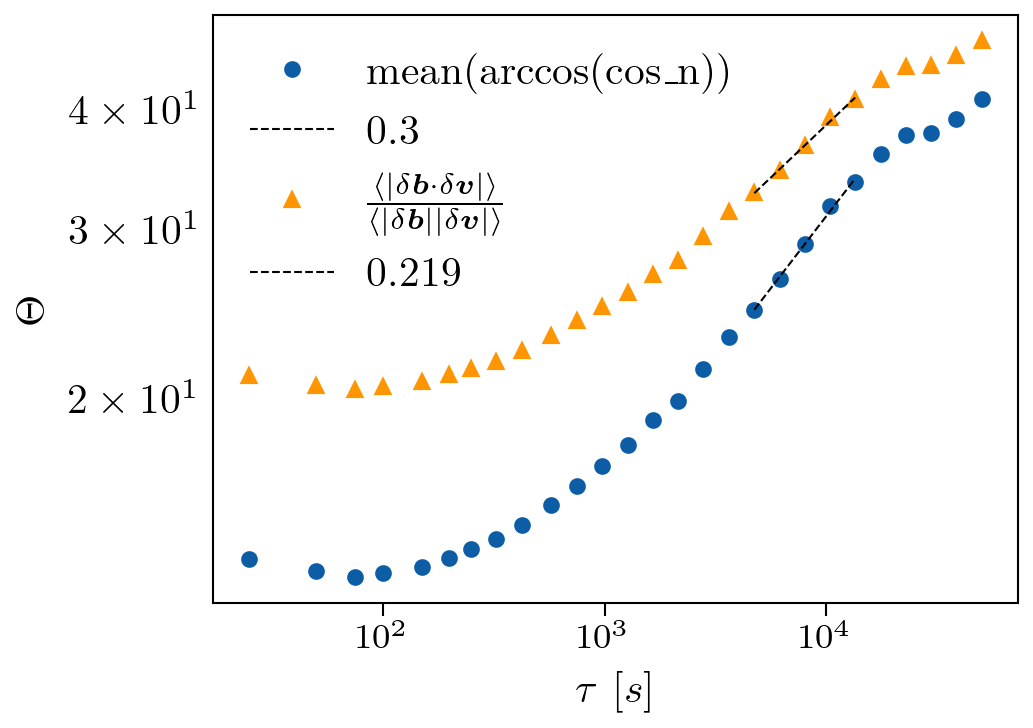

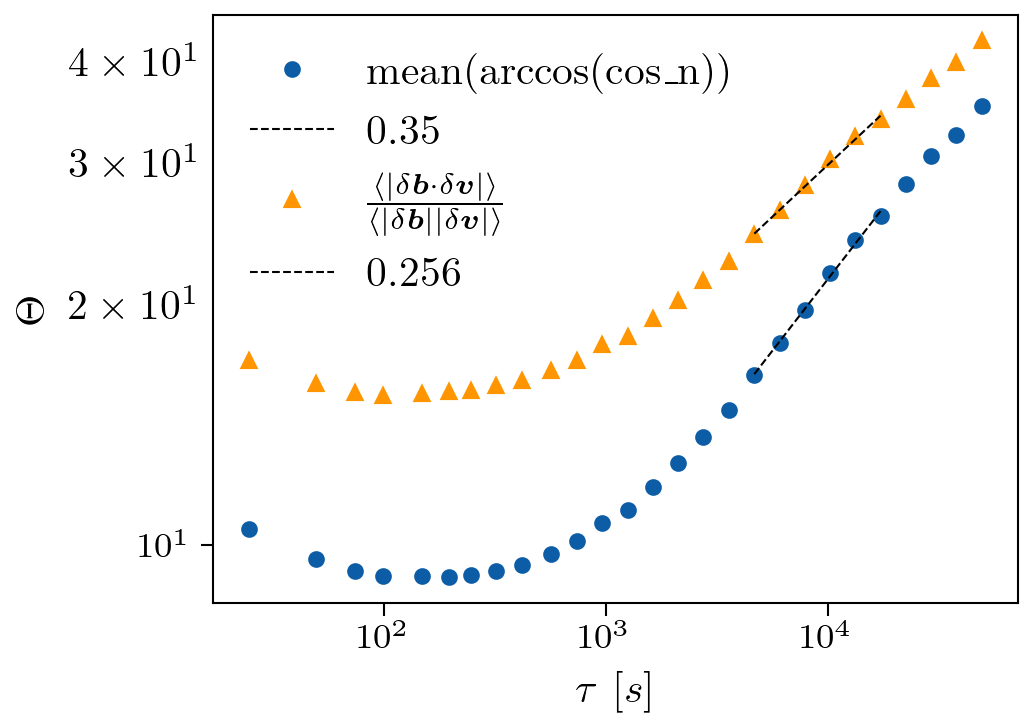

In [207]:
def giannis_func(B, V, N, tau_values):
    def norma(df):
        """
        Compute the Euclidean norm of a dataframe with columns 'x', 'y', and 'z'.

        Args:
            df (pandas.DataFrame): Dataframe with columns 'x', 'y', and 'z'.

        Returns:
            pandas.Series: Series with the Euclidean norm of the dataframe.

        """
        keys = list(df.keys())

        norm = np.sqrt(df[keys[0]]**2+df[keys[1]]**2+df[keys[2]]**2)
        return norm


    def unit_vec(df):
        """
        Compute the unit vector of a dataframe with columns 'x', 'y', and 'z'.

        Args:
            df (pandas.DataFrame): Dataframe with columns 'x', 'y', and 'z'.

        Returns:
            pandas.DataFrame: Dataframe with the unit vector of the input dataframe.

        """
        norm = norma(df)
        df_u = df.div(norm, axis=0)
        return df_u


    def inner_prod(df1, df2):
        """
        Compute the inner product of two dataframes with columns 'x', 'y', and 'z'.

        Args:
            df1 (pandas.DataFrame): First dataframe with columns 'x', 'y', and 'z'.
            df2 (pandas.DataFrame): Second dataframe with columns 'x', 'y', and 'z'.

        Returns:
            pandas.Series: Series with the inner product of the two dataframes.

        """
        keys1 = list(df1.keys())
        keys2 = list(df2.keys())

        prod = df1[keys1[0]]*df2[keys2[0]] + df1[keys1[1]]*df2[keys2[1]] + df1[keys1[2]]*df2[keys2[2]]
        return prod


    # Calculate db
    db = {}

    for tau in tau_values:

        B_shifted = B.shift(periods=-tau)

        ### This product is WRONG, it needs to be time-wise
        db_tau = (B_shifted - B)

        db[str(tau)] = db_tau

    # Calculate dv
    dv = {}

    for tau in tau_values:

        V_shifted = V.shift(periods=-tau)

        dv_tau = (V_shifted - V)

        dv[str(tau)] = dv_tau

    # Calculate b_l (local)
    b_l = {}

    for tau in tau_values:

        ### Needs to be checked!
        b_l_tau = B.rolling(3*tau,closed = 'both').mean()
        b_l_tau = b_l_tau.shift(periods=-2*tau)

        b_l[str(tau)] = b_l_tau

    # Calculate u (local)
    u = {}

    for tau in tau_values:
        u_tau = unit_vec(b_l[str(tau)])

        u[str(tau)] = u_tau

    # Calculate dv_perp
    dv_perp = {}

    for tau in tau_values:
        keys_dv = list(dv[str(tau)].keys())
        keys_u   = list(u[str(tau)].keys())

        dv_perp_tau = dv[str(tau)].copy()
        for i in range(len(keys_dv)):

            dv_perp_tau[keys_dv[i]] = dv[str(tau)][keys_dv[i]] - inner_prod(dv[str(tau)],u[str(tau)])*u[str(tau)][keys_u[i]]

        dv_perp[str(tau)] = dv_perp_tau

    # Calculate db_perp
    db_perp = {}

    for tau in tau_values:
        keys_db = list(db[str(tau)].keys())
        keys_u = list(u[str(tau)].keys())

        db_perp_tau = db[str(tau)].copy()
        for i in range(len(keys_db)):

            db_perp_tau[keys_db[i]] = db[str(tau)][keys_db[i]] - inner_prod(db[str(tau)],u[str(tau)])*u[str(tau)][keys_u[i]]

        db_perp[str(tau)] = db_perp_tau

    # Calculate cos_n, i.e. cos_n = cos(theta_n)
    cos_n   = {}
    theta_n = {}
    w_n     = {}

    for tau in tau_values:

        arithm = np.abs(inner_prod(dv_perp[str(tau)],db_perp[str(tau)]))

        paron = norma(dv_perp[str(tau)])*norma(db_perp[str(tau)])

        cos_n[str(tau)] = arithm/paron

        # Temporary w_n
        w_n[str(tau)] = paron

        th_1              = np.arccos(arithm/paron)*180/np.pi
        theta_n[str(tau)] = th_1


    # cos_mean = []
    theta_mean = []

    for tau in tau_values:
        # Correct w_n
        w_n[str(tau)] = w_n[str(tau)]/(w_n[str(tau)].sum())


        # Final th_n
        final_th_n = theta_n[str(tau)]*w_n[str(tau)]

        # cos_mean.append(cos_n[str(tau)].mean())
        theta_mean.append(final_th_n.sum())

    # theta_cos_mean                    = np.arccos(cos_mean)*180/np.pi
    # theta_cos_mean[theta_cos_mean>90] = 180 - theta_cos_mean[theta_cos_mean>90]



    theta_n_CH = {}

    for tau in tau_values:
        try:
            arithm               = np.nanmean(np.abs(inner_prod(dv_perp[str(tau)].dropna(),db_perp[str(tau)].dropna())))
            paron                = np.nanmean(norma(dv_perp[str(tau)].dropna())*norma(db_perp[str(tau)].dropna()))
            th_1                 = np.arccos(arithm/paron)*180/np.pi
            theta_n_CH[str(tau)] = th_1
        except:
            theta_n_CH[str(tau)] = np.nan

    #Also estimate x values in di
    l_di = (tau_values)*dt#*Vsw)/di
    
    return l_di, theta_mean,theta_n_CH





start_times = ['1995-01-01', '1996-05-15', '1997-01-08', '2000-08-23']
end_times   = ['1995-07-29', '1996-08-16', '1997-06-09', '2001-02-15']


from cdasws import CdasWs
cdas = CdasWs()

#  Edit the following vars, time variables, and printing to suit your environment
# (spacepy or cdflib) and needs.
for metr in range(len(start_times)):
    start_time = start_times[metr]
    end_time   = end_times[metr]
    
    vars         = ['MOM.P.MAGF','MOM.P.DENSITY','MOM.P.VELOCITY','TIME']
    time         = [start_time, end_time]
    status, data = cdas.get_data('WI_PLSP_3DP', vars, time[0], time[1])

    
    import numpy as np
    import pandas as pd
    import scipy.constants

    # Set parameters
    max_hours = 15
    Estimate_5point = True # Added functionality for 5 point structure functions. Check https://iopscience.iop.org/article/10.3847/1538-4357/ab99ca/pdf


    # Create dataframes for B, V, and N
    B = pd.DataFrame({'DateTime': data['Epoch'],
                      'Br': data['MOM$P$MAGF'].T[0],
                      'Bt': data['MOM$P$MAGF'].T[1],
                      'Bn': data['MOM$P$MAGF'].T[2]
                     }).set_index('DateTime').interpolate()

    V = pd.DataFrame({'DateTime': data['Epoch'],
                      'Vr': data['MOM$P$VELOCITY'].T[0],
                      'Vt': data['MOM$P$VELOCITY'].T[1],
                      'Vn': data['MOM$P$VELOCITY'].T[2]
                     }).set_index('DateTime').interpolate()

    N = pd.DataFrame({'DateTime': data['Epoch'],
                      'N': data['MOM$P$DENSITY']
                     }).set_index('DateTime').interpolate()

    # Estimate lags
    dt          = func.find_cadence(B)
    max_lag = int((max_hours*3600)/dt)
    tau_values = np.unique((1.3**np.arange(0, 1000)).astype(int))
    tau_values = tau_values[(tau_values<max_lag) & (tau_values>0)]

    N = N[~np.isinf(N.values)]

    # Normalize magnetic field with kinetic energy density
    kinet_normal          = 1e-15 / np.sqrt(scipy.constants.mu_0 * N['N'].values* scipy.constants.m_p)
    B[['Br', 'Bt', 'Bn']] *= kinet_normal.reshape(-1, 1)
    
    
    l_di, theta_mean, theta_n_CH = giannis_func(B, V, dt, tau_values)
    giannis_plot(l_di, theta_mean, theta_n_CH)

In [198]:

def giannis_plot(l_di, theta_mean, theta_n_CH):
    x01, xf1    = 5000, 20000

    end_2 = 32

    # fit_th, s_th, e_th, x_th, y_th = func.find_fit(l_di, theta_mean, x0 = 1e2, xf = 1e4)
    # plt.plot(x_th, y_th, '--', label = 'fit')

    # fit_c, s_c, e_c, x_c, y_c = func.find_fit(l_di, theta_cos_mean, x0 = 1e2, xf = 1e4)
    # plt.plot(x_c, y_c, '--', label = 'fit')

    fig, ax = figs.initializeFigure(r'$\Theta$', r'$\tau ~[s]$')



    plt.loglog(l_di, theta_mean, label = 'mean(arccos(cos_n))')

    fit1, s1, e1, x1, y1 =func.find_fit(l_di, np.array(theta_mean), x01, xf1)
    plt.semilogx(x1[s1:e1], fit1[2], ms=0,c='k', ls='--', lw=0.5, label =round(fit1[0][1],2))
    
    plt.loglog(l_di, list(theta_n_CH.values()), label = r'$\frac{\langle |\delta \boldsymbol{b}  \cdot \delta\boldsymbol{v}| \rangle}{ \langle |\delta \boldsymbol{b}| |\delta  \boldsymbol{v}| \rangle}$')
    fit1, s1, e1, x1, y1 =func.find_fit(l_di, list(theta_n_CH.values()), x01, xf1)
    plt.loglog(x1[s1:e1], fit1[2], ms=0,c='k', ls='--', lw=0.5, label =round(fit1[0][1],3))


    plt.legend()
    plt.show()
    return


(array([2.4091000e+01, 4.8182000e+01, 7.2273000e+01, 9.6364000e+01,
        1.4454600e+02, 1.9272800e+02, 2.4091000e+02, 3.1318300e+02,
        4.0954700e+02, 5.5409300e+02, 7.2273000e+02, 9.3954900e+02,
        1.2286410e+03, 1.5900060e+03, 2.0718260e+03, 2.6981920e+03,
        3.5172860e+03, 4.5772900e+03, 5.9504770e+03, 7.7332110e+03,
        1.0045947e+04, 1.3057322e+04, 1.6984155e+04, 2.2091447e+04,
        2.8716472e+04, 3.7341050e+04, 4.8543365e+04]),
 {'1': nan,
  '2': nan,
  '3': nan,
  '4': nan,
  '6': nan,
  '8': nan,
  '10': nan,
  '13': nan,
  '17': nan,
  '23': nan,
  '30': nan,
  '39': nan,
  '51': nan,
  '66': nan,
  '86': nan,
  '112': nan,
  '146': nan,
  '190': nan,
  '247': nan,
  '321': nan,
  '417': nan,
  '542': nan,
  '705': nan,
  '917': nan,
  '1192': nan,
  '1550': nan,
  '2015': nan})